# Predicting Bike Rentals

In this project I will be working with a dataset on bike rentals in Washington, D.C. The dataset is available from the University of California, Irvine's Machine Learing Repository [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

The dataset has the following columns:
- `instant` - A unique sequential ID number for each row
- `dteday` - Date of the rentals
- `seaso`n - Season in which the rentals occurred
- `yr` - Year the rentals occurred
- `mnth` - Month the rentals occurred
- `hr` - Hour the rentals occurred
- `holiday` - Whether or not it was a holiday
- `weekday` - Day of the week (numbered 0-7)
- `workingday` - Whether it was a working day
- `weathersit` - Weather (categories)
- `temp` - Temperature (0-1 scale)
- `atempt` - Adjusted temperature
- `hum` - Humidity (0-1 scale)
- `windspeed` - Wind speed (0-1 scale)
- `casual` - Number of casual riders (not previously registered with rental scheme)
- `registered` - Number of registered riders
- `cnt` - Number of bike rentals (casual plus registered)

The aim of this project is to predict the total number of bikes people rented in a given hour, i.e. predicting the `cnt` column. This will be done using all columns except for `casual` and `registered`. Let's read in the data and get an overview.

In [1]:
import pandas as pd
bike_rentals = pd.read_csv('hour.csv')
print(bike_rentals.head(), bike_rentals.shape)

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1   (17379, 17)


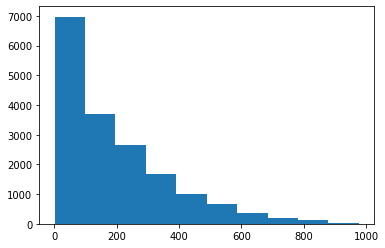

In [7]:
import matplotlib.pyplot as plt
plt.hist(bike_rentals['cnt'])
plt.show()

In [27]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [6]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating Features

Before building a machine learning model, I will create some features which may strengthen the accuracy of the model. Specifically, the `hr` column contains the hours 1-24 but a model will treat each number independently rather than understanding the relationship between the numbers. I will use the `hr` column to create a new column with labels for `morning`, `afternoon`, `evening` and `night`.

In [17]:
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4 #night
    elif hour >= 6 and hour < 12:
        return 1 #morning
    elif hour >= 12 and hour < 18:
        return 2 #afternoon
    elif hour >= 18 and hour <= 24:
        return 3 #evening
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label'].head()

0    4
1    4
2    4
3    4
4    4
Name: time_label, dtype: int64

In [19]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
time_label   -0.378318
Name: cnt, dtype: float64

## Splitting the Data into Train and Test Sets

The data can now be split into training and testing data. For this model I will use mean squared error (MSE) as my error metric, which works well on continuous data and will highlight large errors.

Let's set a random permutaion on the index (and reindex it), then split our data as follows:

Training dataset = 80% of bike_rentals

Testing dataset = Remaining 20%

In [18]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

In [65]:
# Creating the predictor columns
features = list(train.columns)
features.remove('cnt')
features.remove('casual')
features.remove('dteday')
features.remove('registered')

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train['cnt'])
prediction = lr.predict(test[features])
mse = mean_squared_error(test['cnt'], prediction)
print(mse)

17739.501427202147


The error is very high, which could be caused by some very high rental counts. Let's compare this error with that of a decision tree algorithm.

## Applying Decision Trees

In [66]:
from sklearn.tree import DecisionTreeRegressor
dtg = DecisionTreeRegressor()
dtg.fit(train[features], train['cnt'])
prediction = dtg.predict(test[features])

mse = mean_squared_error(test['cnt'], prediction)
print(mse)

3327.525316455696


The error is significantly improved through the use of this algorithm. Let's experiment with parameters to see if we can improve further.

In [67]:
dtg2 = DecisionTreeRegressor(max_depth=19, min_samples_split=25, random_state=1)
dtg2.fit(train[features], train['cnt'])
prediction2 = dtg2.predict(test[features])

mse2 = mean_squared_error(test['cnt'], prediction2)
print(mse2)

dtg3 = DecisionTreeRegressor(max_depth=19, min_samples_leaf=11, random_state=1)
dtg3.fit(train[features], train['cnt'])
prediction3 = dtg3.predict(test[features])

mse3 = mean_squared_error(test['cnt'], prediction3)
print(mse3)

2524.826413715259
2547.5392727957606


By modifying the depth of the tree, the minimum number of samples required to split a node or to be considered a leaf, the error has reduced again. 

Now we can apply the random forest algorithm, which tends to be more accurate. 

## Applying Random Forests

In [68]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train[features], train['cnt'])
prediction = rf.predict(test[features])

mse = mean_squared_error(test['cnt'], prediction)
print(mse)

1681.3833607882623


The baseline algorithm was more accurate than the tuned decision tree model. Let's experiment with parameters to see if error can be reduced.

In [114]:
rf = RandomForestRegressor(n_estimators=200, max_depth=17, min_samples_split=15, random_state=1)
rf.fit(train[features], train['cnt'])
prediction = rf.predict(test[features])

mse = mean_squared_error(test['cnt'], prediction)
print(mse)

1740.1830084709027


Unfortunately despite extensive modification to parameters of the Random Forest Regressor model, the error did not drop below the 'off the shelf' approach.

Alternative ways to improve the error would be to create and utilise different features.